In [1]:
!pip install -U efficientnet opendatasets --quiet

     |████████████████████████████████| 50 kB 7.6 MB/s 


In [2]:
import opendatasets as od

url = "https://www.kaggle.com/competitions/kitchenware-classification/data"
od.download(url)

100%|██████████| 1.63G/1.63G [01:23<00:00, 21.0MB/s]



Extracting archive ./kitchenware-classification/kitchenware-classification.zip to ./kitchenware-classification


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Activation,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.models import Model
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
import efficientnet.keras as efn
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
def append_ext(fp):
  return fp + ".jpg"

In [5]:
train_df = pd.read_csv("./kitchenware-classification/train.csv", dtype=str)
test_df = pd.read_csv("./kitchenware-classification/test.csv", dtype=str)
submit_df = pd.read_csv("./kitchenware-classification/sample_submission.csv")

In [6]:
train_df["Id"] = train_df["Id"].apply(append_ext)
test_df["Id"] = test_df["Id"].apply(append_ext)

In [7]:
datagen = ImageDataGenerator(
    rescale = 1./255., 
    validation_split=0.25,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Import data from dataframes and directories and turn it into batches
efn_train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

efn_valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224,224)
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.
Found 3808 validated image filenames.


# EfficientNetB7

In [8]:
base_model = efn.EfficientNetB7(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation="softmax")(x)

model_10 = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_10.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = efn_train_generator.n // efn_train_generator.batch_size
STEP_SIZE_VALID = efn_valid_generator.n // efn_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_10 = model_10.fit(
    efn_train_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=efn_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

258434480/258434480 [==============================] - 31s 0us/step
Epoch 1/10
130/130 [==============================] - 164s 1s/step - loss: 2.8099 - accuracy: 0.7177 - val_loss: 0.4438 - val_accuracy: 0.8895
Epoch 2/10
130/130 [==============================] - 139s 1s/step - loss: 1.5069 - accuracy: 0.7929 - val_loss: 0.4641 - val_accuracy: 0.8844
Epoch 3/10
130/130 [==============================] - 133s 1s/step - loss: 1.4775 - accuracy: 0.8033 - val_loss: 0.3357 - val_accuracy: 0.9121
Epoch 4/10
130/130 [==============================] - 138s 1s/step - loss: 1.5248 - accuracy: 0.8151 - val_loss: 0.3186 - val_accuracy: 0.9062
Epoch 5/10
130/130 [==============================] - 140s 1s/step - loss: 1.3358 - accuracy: 0.8168 - val_loss: 0.3173 - val_accuracy: 0.9026
Epoch 6/10
130/130 [==============================] - 145s 1s/step - loss: 1.2764 - accuracy: 0.8340 - val_loss: 0.2947 - val_accuracy: 0.9157
Epoch 7/10
130/130 [==============================] - 150s 1s/step - loss:

In [9]:
max_val_accuracy = max(history_10.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9186


In [10]:
score = model_10.evaluate(efn_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  0.2978
Test accuracy  :  92.0806%


In [11]:
df_model10 = pd.DataFrame(history_10.history)
df_model10.head()

,loss,accuracy,val_loss,val_accuracy
0,2.809899,0.717738,0.443813,0.889535
1,1.506875,0.792895,0.464054,0.884448
2,1.477470,0.803287,0.335696,0.912064
3,1.524758,0.815128,0.318562,0.906250
4,1.335850,0.816820,0.317308,0.902616


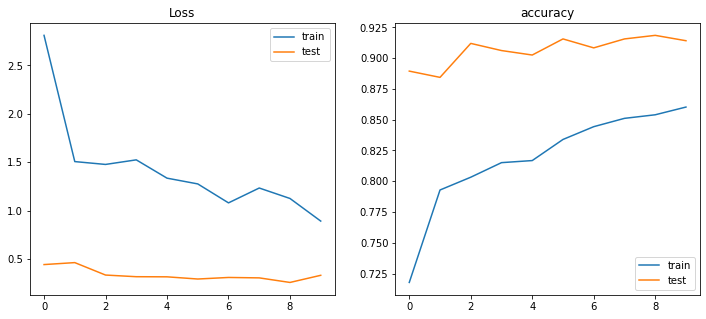

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model10)), df_model10.loss, label="train")
plt.plot(range(len(df_model10)), df_model10.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model10)), df_model10.accuracy, label="train")
plt.plot(range(len(df_model10)), df_model10.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

# Model 10 bis less freezing layers, 

In [24]:
base_model = efn.EfficientNetB7(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation="softmax")(x)

model_10B = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_10B.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = efn_train_generator.n // efn_train_generator.batch_size
STEP_SIZE_VALID = efn_valid_generator.n // efn_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_10B = model_10B.fit(
    efn_train_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=efn_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/10
130/130 [==============================] - 154s 1s/step - loss: 2.5844 - accuracy: 0.7366 - val_loss: 0.4515 - val_accuracy: 0.8961
Epoch 2/10
130/130 [==============================] - 131s 1s/step - loss: 1.1913 - accuracy: 0.8250 - val_loss: 0.2712 - val_accuracy: 0.9179
Epoch 3/10
130/130 [==============================] - 130s 1s/step - loss: 0.6429 - accuracy: 0.8540 - val_loss: 0.2992 - val_accuracy: 0.9092
Epoch 4/10
130/130 [==============================] - 130s 999ms/step - loss: 0.5962 - accuracy: 0.8562 - val_loss: 0.2840 - val_accuracy: 0.9281
Epoch 5/10
130/130 [==============================] - 131s 1s/step - loss: 0.4998 - accuracy: 0.8789 - val_loss: 0.2830 - val_accuracy: 0.9230
Epoch 6/10
130/130 [==============================] - 130s 1s/step - loss: 0.4771 - accuracy: 0.8751 - val_loss: 0.2692 - val_accuracy: 0.9281
Epoch 7/10
130/130 [==============================] - 131s 1s/step - loss: 0.4320 - accuracy: 0.8794 - val_loss: 0.3125 - val_accuracy: 0.9

In [25]:
max_val_accuracy = max(history_10B.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9390


In [26]:
score = model_10B.evaluate(efn_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  0.2990
Test accuracy  :  93.5925%


In [27]:
df_model10B = pd.DataFrame(history_10B.history)
df_model10B.head()

,loss,accuracy,val_loss,val_accuracy
0,2.584436,0.736588,0.451460,0.896076
1,1.191265,0.825036,0.271169,0.917878
2,0.642909,0.854036,0.299195,0.909157
3,0.596204,0.856211,0.283978,0.928052
4,0.499766,0.878927,0.282966,0.922965


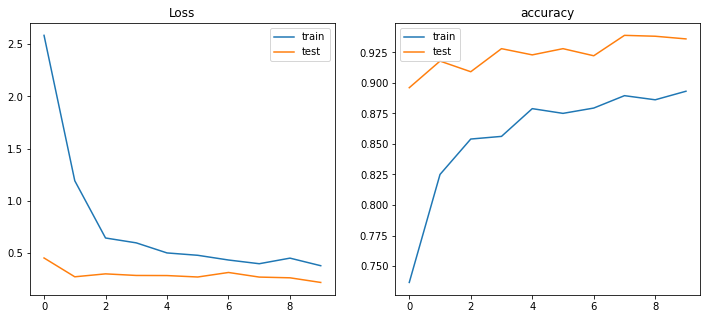

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model10B)), df_model10B.loss, label="train")
plt.plot(range(len(df_model10B)), df_model10B.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model10B)), df_model10B.accuracy, label="train")
plt.plot(range(len(df_model10B)), df_model10B.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

---
# Model 10B customized (try)

In [43]:
base_model = efn.EfficientNetB7(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation="softmax")(x)

model_11 = Model(inputs=base_model.input, outputs=x)


# Compile the model
model_11.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.Adam(),
    optimizer=tf.keras.optimizers.RMSprop(2e-4),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = efn_train_generator.n // efn_train_generator.batch_size
STEP_SIZE_VALID = efn_valid_generator.n // efn_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_11 = model_11.fit(
    efn_train_generator,
    epochs=20,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=efn_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/20
130/130 [==============================] - 153s 1s/step - loss: 2.7497 - accuracy: 0.7533 - val_loss: 0.5050 - val_accuracy: 0.8939
Epoch 2/20
130/130 [==============================] - 130s 1s/step - loss: 1.1802 - accuracy: 0.8277 - val_loss: 0.3400 - val_accuracy: 0.9012
Epoch 3/20
130/130 [==============================] - 130s 1s/step - loss: 0.8679 - accuracy: 0.8490 - val_loss: 0.2951 - val_accuracy: 0.9186
Epoch 4/20
130/130 [==============================] - 131s 1s/step - loss: 0.6209 - accuracy: 0.8555 - val_loss: 0.3213 - val_accuracy: 0.8990
Epoch 5/20
130/130 [==============================] - 130s 996ms/step - loss: 0.4946 - accuracy: 0.8693 - val_loss: 0.2915 - val_accuracy: 0.9302
Epoch 6/20
130/130 [==============================] - 130s 1s/step - loss: 0.4846 - accuracy: 0.8806 - val_loss: 0.2859 - val_accuracy: 0.9288
Epoch 7/20
130/130 [==============================] - 132s 1s/step - loss: 0.4351 - accuracy: 0.8775 - val_loss: 0.2867 - val_accuracy: 0.9

In [44]:
max_val_accuracy = max(history_11.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9426


In [45]:
score = model_11.evaluate(efn_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  0.2830
Test accuracy  :  93.9525%


In [46]:
df_model11 = pd.DataFrame(history_11.history)
df_model11.head()

,loss,accuracy,val_loss,val_accuracy
0,2.749734,0.753262,0.505021,0.893895
1,1.180160,0.827695,0.340039,0.901163
2,0.867949,0.848961,0.295131,0.918605
3,0.620930,0.855486,0.321325,0.898983
4,0.494573,0.869260,0.291517,0.930233


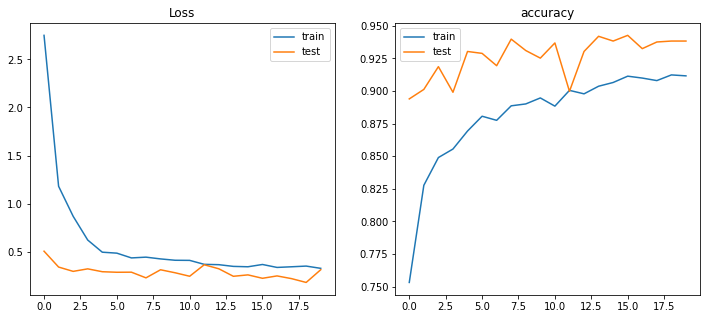

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model11)), df_model11.loss, label="train")
plt.plot(range(len(df_model11)), df_model11.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model11)), df_model11.accuracy, label="train")
plt.plot(range(len(df_model11)), df_model11.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

In [48]:
# Predict the output
test_generator.reset()

y_softmax = model_11.predict(
    test_generator,
    steps=STEP_SIZE_SET,
    verbose=1,
)

119/119 [==============================] - 63s 489ms/step


In [49]:
y_preds = np.argmax(y_softmax, axis=-1)

In [50]:
labels = (efn_train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_preds]

In [51]:
filenames = test_generator.filenames
r = pd.DataFrame({"Filename":filenames,
                      "label":predictions})

submit_df['label'] = r['label']
submit_df.to_csv("results_2.csv",index=False)

In [52]:
model_11.save("model_11.h5")

---
# epochs = 50

In [ ]:
base_model = efn.EfficientNetB7(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation="softmax")(x)

model_12 = Model(inputs=base_model.input, outputs=x)


# Compile the model
model_12.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.Adam(),
    optimizer=tf.keras.optimizers.RMSprop(2e-4),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = efn_train_generator.n // efn_train_generator.batch_size
STEP_SIZE_VALID = efn_valid_generator.n // efn_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_12 = model_12.fit(
    efn_train_generator,
    epochs=50,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=efn_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/50
130/130 [==============================] - 156s 1s/step - loss: 2.6872 - accuracy: 0.7387 - val_loss: 0.5163 - val_accuracy: 0.8903
Epoch 2/50
130/130 [==============================] - 129s 991ms/step - loss: 1.1509 - accuracy: 0.8308 - val_loss: 0.4067 - val_accuracy: 0.9055
Epoch 3/50
130/130 [==============================] - 130s 999ms/step - loss: 0.8867 - accuracy: 0.8487 - val_loss: 0.3145 - val_accuracy: 0.9142
Epoch 4/50
130/130 [==============================] - 129s 992ms/step - loss: 0.6018 - accuracy: 0.8606 - val_loss: 0.2803 - val_accuracy: 0.9135
Epoch 5/50
130/130 [==============================] - 130s 998ms/step - loss: 0.4707 - accuracy: 0.8799 - val_loss: 0.2847 - val_accuracy: 0.9288
Epoch 6/50
130/130 [==============================] - 129s 990ms/step - loss: 0.4805 - accuracy: 0.8765 - val_loss: 0.2520 - val_accuracy: 0.9222
Epoch 7/50
130/130 [==============================] - 130s 1s/step - loss: 0.4127 - accuracy: 0.8852 - val_loss: 0.2580 - val_a

In [ ]:
max_val_accuracy = max(history_12.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

In [ ]:
score = model_12.evaluate(efn_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

In [ ]:
df_model12 = pd.DataFrame(history_11.history)
df_model12.head()

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model12)), df_model12.loss, label="train")
plt.plot(range(len(df_model12)), df_model12.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model12)), df_model12.accuracy, label="train")
plt.plot(range(len(df_model12)), df_model12.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

---
#ResNet

In [18]:
datagen = ImageDataGenerator(
    rescale = 1./255., 
    validation_split=0.25,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True,
    rotation_range=20,
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Import data from dataframes and directories and turn it into batches
rn_train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

rn_valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224,224)
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.
Found 3808 validated image filenames.


In [19]:
base_model = ResNet50(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(6, activation='softmax')(x)


model_11 = Model(inputs, outputs)

# Compile the model
model_11.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = rn_train_generator.n // rn_train_generator.batch_size
STEP_SIZE_VALID = rn_valid_generator.n // rn_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_11 = model_11.fit(
    rn_train_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=rn_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

Epoch 1/10
130/130 [==============================] - 119s 893ms/step - loss: 1.7658 - accuracy: 0.2267 - val_loss: 1.7194 - val_accuracy: 0.2980
Epoch 2/10
130/130 [==============================] - 114s 876ms/step - loss: 1.7136 - accuracy: 0.2661 - val_loss: 1.7242 - val_accuracy: 0.2071
Epoch 3/10
130/130 [==============================] - 115s 883ms/step - loss: 1.6790 - accuracy: 0.3105 - val_loss: 1.6791 - val_accuracy: 0.3132
Epoch 4/10
130/130 [==============================] - 114s 875ms/step - loss: 1.6579 - accuracy: 0.3270 - val_loss: 1.6420 - val_accuracy: 0.3001
Epoch 5/10
130/130 [==============================] - 115s 889ms/step - loss: 1.6411 - accuracy: 0.3197 - val_loss: 1.6260 - val_accuracy: 0.3532
Epoch 6/10
130/130 [==============================] - 115s 882ms/step - loss: 1.6237 - accuracy: 0.3700 - val_loss: 1.6103 - val_accuracy: 0.3692
Epoch 7/10
130/130 [==============================] - 117s 903ms/step - loss: 1.6178 - accuracy: 0.3400 - val_loss: 1.6455 -

In [20]:
max_val_accuracy = max(history_11.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.3975


In [21]:
score = model_11.evaluate(rn_valid_generator, verbose=0)
print(f"Test loss  :  {score[0]:5.4f}")
print(f"Test accuracy  :  {100*score[1]:5.4f}%")

Test loss  :  1.5776
Test accuracy  :  39.7408%


In [22]:
df_model11 = pd.DataFrame(history_11.history)
df_model11.head()

,loss,accuracy,val_loss,val_accuracy
0,1.765763,0.226683,1.719380,0.297965
1,1.713630,0.266071,1.724209,0.207122
2,1.679016,0.310537,1.679056,0.313227
3,1.657941,0.326970,1.641991,0.300145
4,1.641113,0.319720,1.626040,0.353198


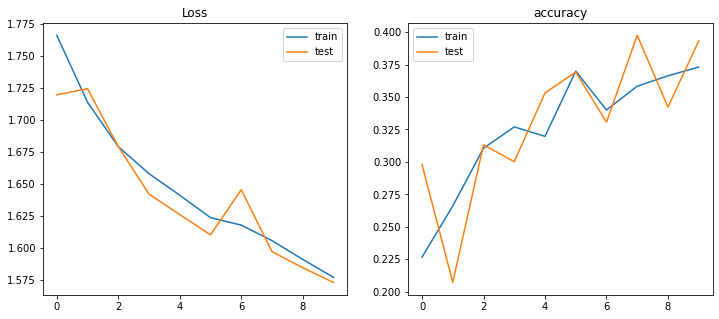

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model11)), df_model11.loss, label="train")
plt.plot(range(len(df_model11)), df_model11.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model11)), df_model11.accuracy, label="train")
plt.plot(range(len(df_model11)), df_model11.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()